In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Đọc dữ liệu từ tập tin CSV với các tùy chọn
df = pd.read_csv('/content/drive/MyDrive/Final/BID_Stock_Data.csv', header=0, parse_dates=[0], index_col=0)
df = df.dropna()  # Drop missing values


In [2]:
# In ra 5 dòng đầu tiên của DataFrame
print(df.head())
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index


                    Open          High           Low         Close  \
Date                                                                 
2014-01-27  13193.956055  13264.512695  12770.621094  12982.289063   
2014-02-06  12841.176758  12911.732422  12417.841797  12417.841797   
2014-02-07  12276.729492  12347.285156  11641.726563  11712.282227   
2014-02-10  11641.726563  12135.618164  11430.058594  11994.505859   
2014-02-11  12135.618164  12135.618164  11923.950195  11923.950195   

               Adj Close     Volume  
Date                                 
2014-01-27  12982.289063  4593392.0  
2014-02-06  12417.841797  1360040.0  
2014-02-07  11712.282227  4234371.0  
2014-02-10  11994.505859  5771436.0  
2014-02-11  11923.950195  2747437.0  


In [3]:
# 2.  chia train test validate theo tỉ lệ 9:1
# Split the data into training, testing
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

X2D = df[['High']] # Biến độc lập theo mảng 2 chiều
Y2D = df[['Close']] # Biến phụ thuộc theo mảng 2 chiều

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

y_train = Y2D[:train_size]
x_train = X2D[:train_size]
y_test = Y2D[train_size:]
x_test = X2D[train_size:]
y_train_index = y_train.index # lấy ra index trước khi đổi nó về mảng 2 chiều ( phục vụ plot )
y_train = Y2D[:train_size].values.ravel()

# Tạo mô hình SVR với kernel RBF
model = SVR(kernel='rbf')
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],             # Ví dụ các giá trị cho C
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Ví dụ các giá trị cho gamma
    'epsilon': [0.001, 0.01, 0.1, 1, 10]      # Ví dụ các giá trị cho epsilon
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Huấn luyện mô hình sử dụng grid search
svr_rbf = grid_search.fit(x_train,y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best parameters: {'C': 1000, 'epsilon': 1, 'gamma': 'scale'}
Best score: 993146.799045122


In [5]:
# dự đoán test

y_pred = svr_rbf.predict(x_test)
y_pred

last_row = df.tail(1)
last_data = last_row['Close'].values.reshape(-1,1)
last_data

array([[41600.]])

In [6]:
# tạo mảng chứa giá trị predict của 30 ngày tiếp theo
x_next_30_days = []
# predict giá Close 30 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(30):
    x_pred_next = svr_rbf.predict(last_data)
    x_next_30_days.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)
x_next_30_days

[array([39932.77995704]),
 array([39128.37157681]),
 array([38521.0920639]),
 array([37996.19597946]),
 array([37508.73360549]),
 array([37035.9417351]),
 array([36564.92871293]),
 array([36088.44884796]),
 array([35603.25200764]),
 array([35109.3186563]),
 array([34609.28154553]),
 array([34107.7123081]),
 array([33610.19960283]),
 array([33122.34531502]),
 array([32648.90571454]),
 array([32193.26397459]),
 array([31757.28386323]),
 array([31341.46215789]),
 array([30945.23904048]),
 array([30567.34119875]),
 array([30206.08155748]),
 array([29859.58644635]),
 array([29525.95065749]),
 array([29203.33395715]),
 array([28890.01532387]),
 array([28584.41908064]),
 array([28285.12358205]),
 array([27990.85979936]),
 array([27700.50454174]),
 array([27413.07119498])]

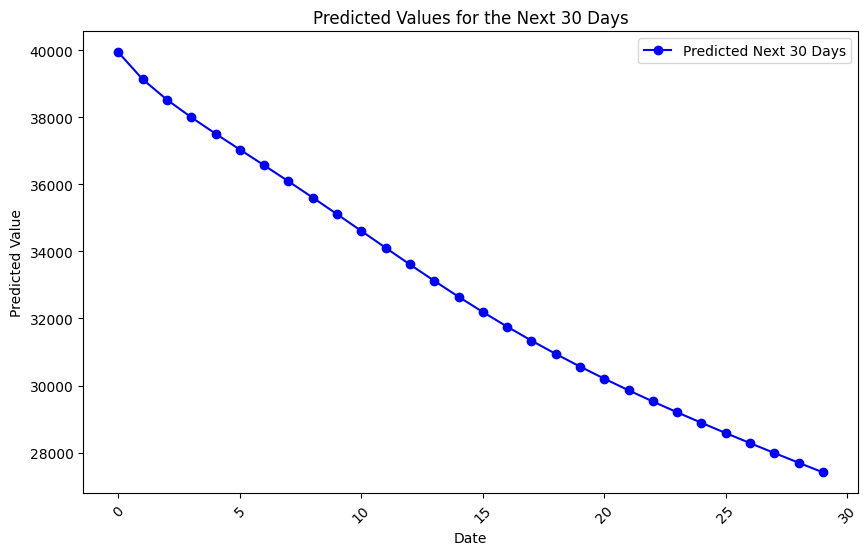

In [7]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(x_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()
# Hiển thị biểu đồ
plt.show()

In [8]:
# Chuyển cột predict price thành mảng 2 chiều
y_pred = y_pred.reshape(-1,1)

In [9]:
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_log_error
# 7. Đánh giá độ chính xác test bằng RMSE, MSLE , MAPE
# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)
# MAPE
test_mape = mean_absolute_percentage_error(y_test,y_pred)
print('Testing MAPE:', test_mape)
# MSLE
test_msle = mean_squared_log_error(y_test,y_pred)
print('Testing MSLE:', test_msle)

Testing RMSE: Close    1056.667642
dtype: float64
Testing MAPE: 0.01935227630715823
Testing MSLE: 0.0006802679899064163


In [10]:
# Tạo index cho 30 ngày tiếp theo
last_index =  df.index[-1]
next_30_dates = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

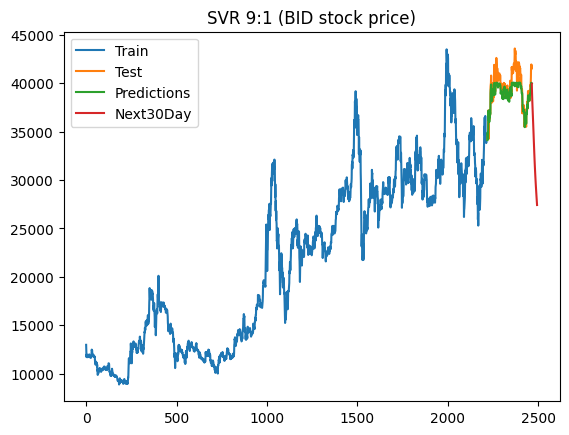

In [11]:
# 9.Vẽ hình

plt.plot(y_train_index, y_train)
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_pred)
plt.plot(next_30_dates,x_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.title('SVR 9:1 (BID stock price)')
plt.show()